In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import os

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy.stats as stats

import seaborn as sns

from datetime import datetime

import re

from tqdm.notebook import tqdm

import dask.dataframe as dd
from dask.distributed import Client

sys.path.insert(0, '../tools/')

from tools import * 

In [4]:
config = pd.Series({
    'path':'../dades',
    'file_type':'csv',
    'years':[2021],
    'dataset': 'BicingNou_ESTACIONS_CLEAN'
})


In [5]:
client = Client()
client

<Client: 'tcp://127.0.0.1:39623' processes=4 threads=16, memory=16.44 GB>

# Read data

In [6]:
%%time

data = read_dask_dataframes(config.path, config.file_type, config.dataset, config.years)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

# config_year.year 

In [7]:
config_year = pd.Series({
    'path':'../dades',
    'file_type':'csv',
    'year':config_year.year,
    'dataset': 'BicingNou_ESTACIONS_MOD'
})

In [8]:
first_size = get_ddf_shape(data[config_year.year])

# Visualization 2021

In [9]:
%%time

data[config_year.year] = load_checkpoint(config_year)

# checkpoint reloaded.

checkpoint reloaded.


In [10]:
%%time

last_size = get_ddf_shape(data[config_year.year])

print('Changes to dataframe durinf preprocessing')
print(f'dropeed {(first_size[0]-last_size[0]):02d} rows')
print(f'dropped {(first_size[0]-last_size[0]):02d} columns')

Changes to dataframe durinf preprocessing
dropeed 02 rows
dropped 02 columns


In [11]:
len(data[config_year.year].divisions) # divisions mark the start and end of each partiotion
# in our case we have nones but that is okay

13

In [12]:
%%time

nans = get_features_nans(data[config_year.year])

zeros = get_features_zero(data[config_year.year])

In [13]:
nans

{}

In [14]:
zeros

{'num_bikes_available': 3.179841885137897,
 'num_bikes_available_types.mechanical': 13.69506730320022,
 'num_bikes_available_types.ebike': 24.63465094207253,
 'num_docks_available': 0.818568669936982,
 'status': 99.94392061117013,
 'is_installed': 0.0016320598204326183,
 'is_renting': 0.061406250743777265,
 'is_returning': 0.061406250743777265,
 'dayofweek': 14.131937982633524,
 'hour': 4.122583106412794}

In [15]:
# nuniques = get_columns_nunique(data[config_year.year])

# pd.Series(nuniques)
# station_id                                  511
# num_bikes_available                        5413
# num_bikes_available_types.mechanical       4950
# num_bikes_available_types.ebike            2412
# num_docks_available                        5641
# last_reported                           3085646
# is_charging_station                           2
# status                                      264
# is_installed                                 50
# is_renting                                  230
# is_returning                                230
# timestamp                                  8700
# year                                          2
# month                                        12
# week                                         53
# dayofweek                                     7
# day                                          31
# dayofyear                                   366
# hour                                         24
# traffic                                    1741
# dtype: int64
    
uniques = get_columns_unique(data[config_year.year])

In [16]:
uniques

{'station_id': 0        1
 1      271
 2      400
 3      510
 4       26
       ... 
 504     79
 505    168
 506     91
 507    467
 508     52
 Name: station_id, Length: 509, dtype: int64,
 'num_bikes_available': 0       43.000000
 1       40.666667
 2       41.000000
 3       42.636364
 4       44.625000
           ...    
 5393    13.305556
 5394    18.035714
 5395    17.527778
 5396     1.058824
 5397    19.595238
 Name: num_bikes_available, Length: 5398, dtype: float64,
 'num_bikes_available_types.mechanical': 0       43.000000
 1       40.666667
 2       41.000000
 3       41.909091
 4       43.625000
           ...    
 4935     1.107143
 4936    16.972222
 4937    16.409091
 4938     1.117647
 4939     7.464286
 Name: num_bikes_available_types.mechanical, Length: 4940, dtype: float64,
 'num_bikes_available_types.ebike': 0        0.000000
 1        0.727273
 2        1.000000
 3        0.800000
 4        0.500000
           ...    
 2404     7.863636
 2405    10.388889
 2406  

## 2021 station_id

In [37]:
%%time

print(stats.describe(data[config_year.year].station_id))
data[config_year.year].station_id.describe().compute()

DescribeResult(nobs=4437921, minmax=(1, 519), mean=261.33176615807264, variance=22296.02133148719, skewness=-0.010847862156955981, kurtosis=-1.1873391353723097)
CPU times: user 755 ms, sys: 206 ms, total: 961 ms
Wall time: 4.6 s


count    4.437921e+06
mean     2.613318e+02
std      1.493185e+02
min      1.000000e+00
25%      1.360000e+02
50%      2.670000e+02
75%      3.940000e+02
max      5.190000e+02
Name: station_id, dtype: float64

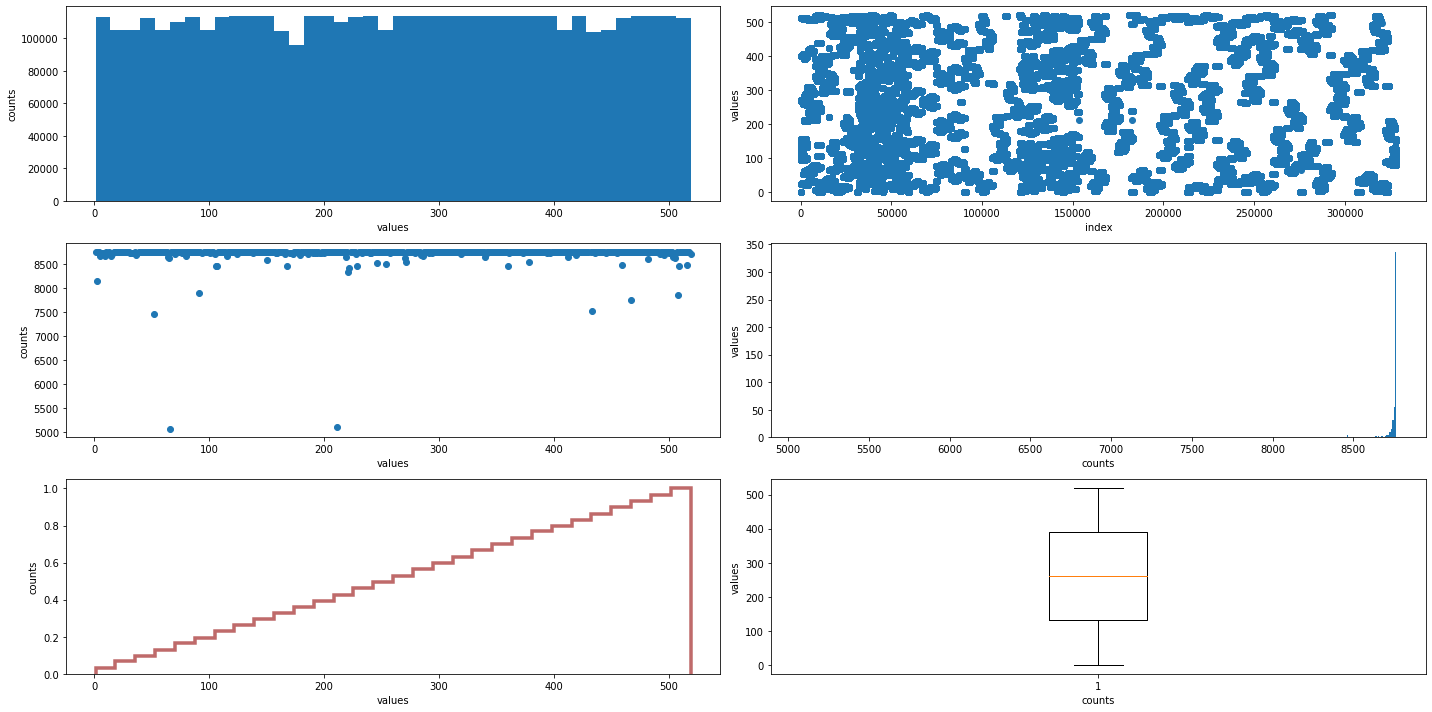

CPU times: user 8.09 s, sys: 337 ms, total: 8.42 s
Wall time: 10 s


In [38]:
%%time

show_counts(data[config_year.year].station_id.compute())

value counts stats {'max': 8763, 'mean': 8718.901768172887, 'median': 8761.0, 'std': 256.85607925377843, 'min': 5079}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.91 s, sys: 0 ns, total: 1.91 s
Wall time: 13.1 s


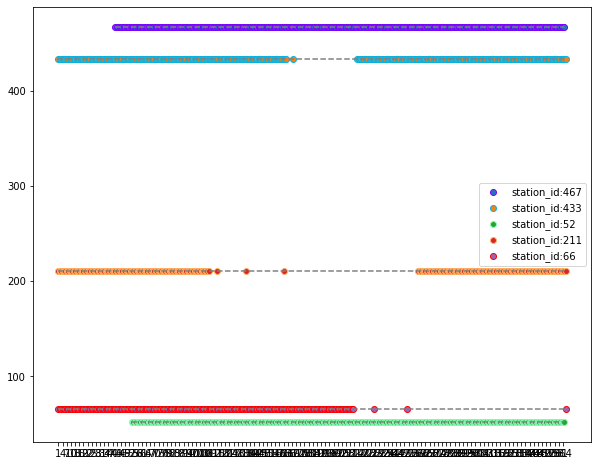

In [39]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofyear', 
    'station_id', 
    'station_id', 
    tail=True, 
    xticks=np.arange(uniques['dayofyear'].min(),uniques['dayofyear'].max(), 3.0),
    figsize=(10,8)
)


## 2021 num_bikes_available

In [40]:
%%time

print(stats.describe(data[config_year.year].num_bikes_available))
data[config_year.year].num_bikes_available.describe().compute()

DescribeResult(nobs=4437921, minmax=(0.0, 54.0), mean=9.736959273000311, variance=65.76056577929182, skewness=0.953276153561145, kurtosis=0.7708515359433252)
CPU times: user 554 ms, sys: 329 ms, total: 883 ms
Wall time: 4.58 s


count    4.437921e+06
mean     9.736959e+00
std      8.109289e+00
min      0.000000e+00
25%      4.000000e+00
50%      9.000000e+00
75%      1.500000e+01
max      5.400000e+01
Name: num_bikes_available, dtype: float64

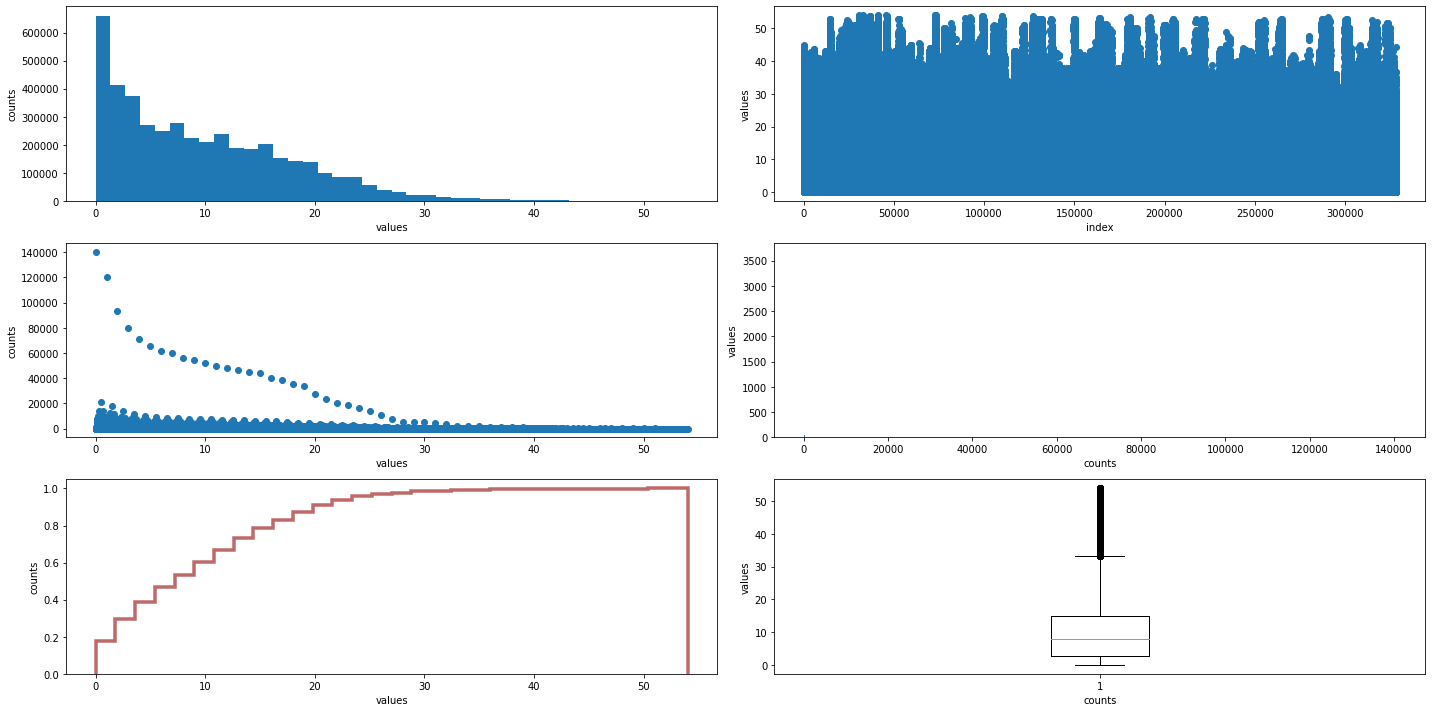

CPU times: user 17.1 s, sys: 1.75 s, total: 18.8 s
Wall time: 20 s


In [41]:
%%time

show_counts(data[config_year.year].num_bikes_available.compute())

348
value counts stats {'max': 8763, 'mean': 8718.901768172887, 'median': 8761.0, 'std': 256.85607925377843, 'min': 5079}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 2.63 s, sys: 0 ns, total: 2.63 s
Wall time: 13.7 s


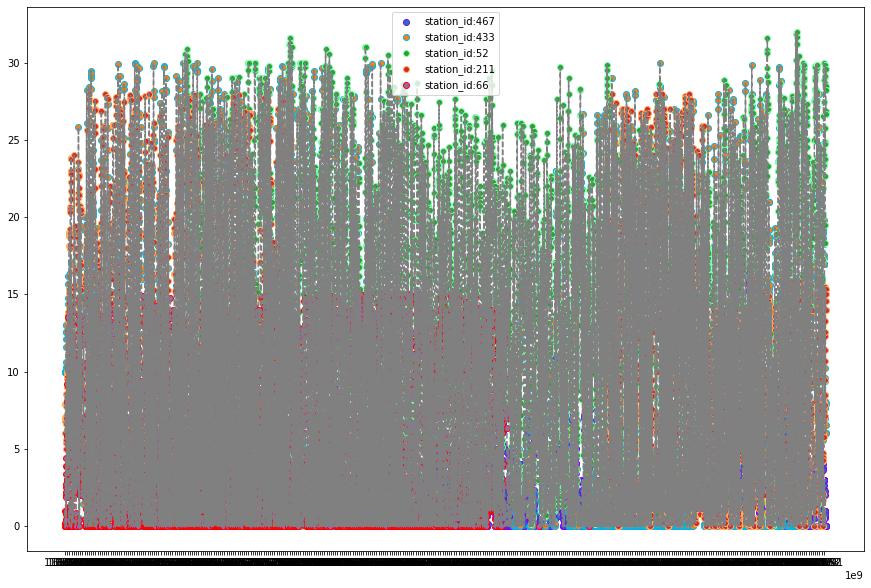

In [42]:
%%time

# Checking availibilty for docks all year
xtikcs_scatter = [uniques['timestamp'][i] for i, x in enumerate(uniques['timestamp']) if i%25==0]
print(len(xtikcs_scatter))

scatter_columns(
    data[config_year.year], 
    'timestamp', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(xtikcs_scatter),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 8763, 'mean': 8718.901768172887, 'median': 8761.0, 'std': 256.85607925377843, 'min': 5079}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.46 s, sys: 245 ms, total: 1.7 s
Wall time: 12.6 s


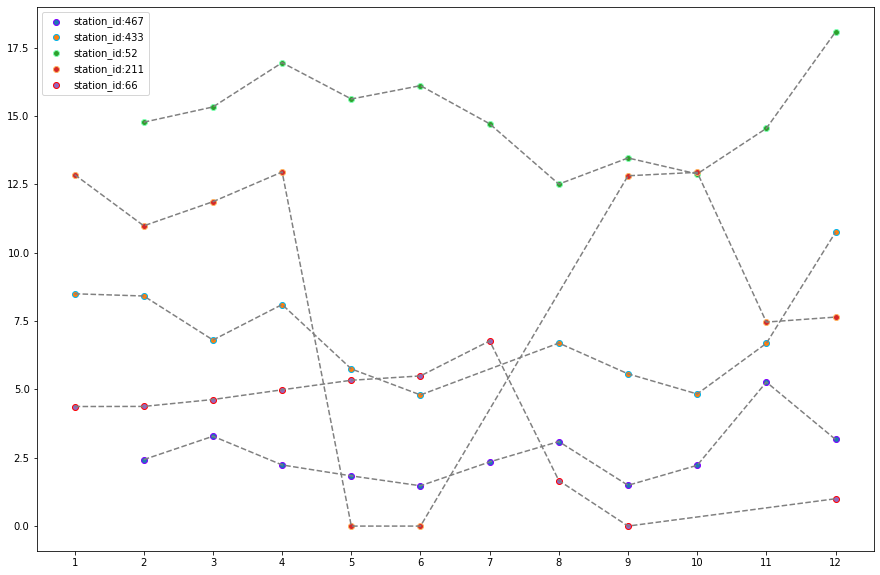

In [43]:
%%time

scatter_columns(
    data[config_year.year], 
    'month', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['month']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8763, 'mean': 8718.901768172887, 'median': 8761.0, 'std': 256.85607925377843, 'min': 5079}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.63 s, sys: 14.2 ms, total: 1.64 s
Wall time: 13.2 s


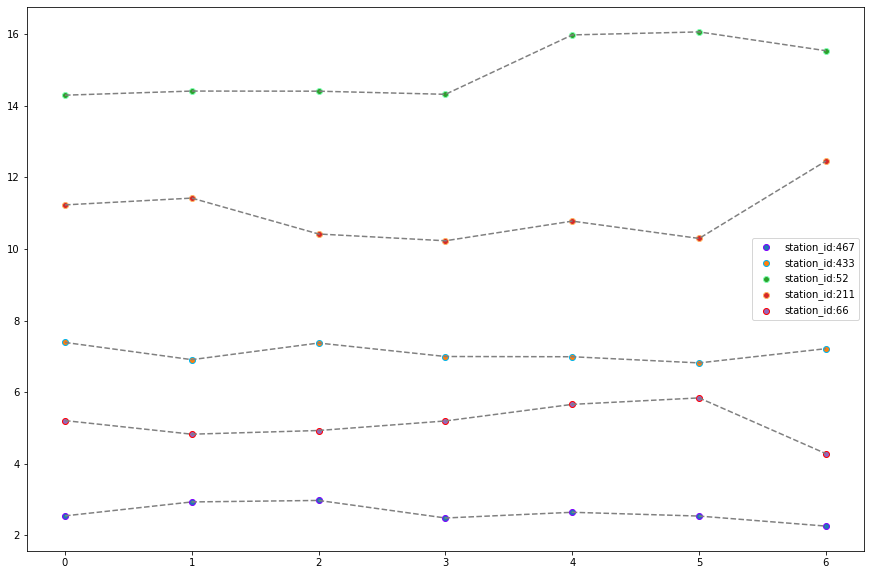

In [44]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofweek', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofweek']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8763, 'mean': 8718.901768172887, 'median': 8761.0, 'std': 256.85607925377843, 'min': 5079}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.58 s, sys: 186 ms, total: 1.77 s
Wall time: 13.2 s


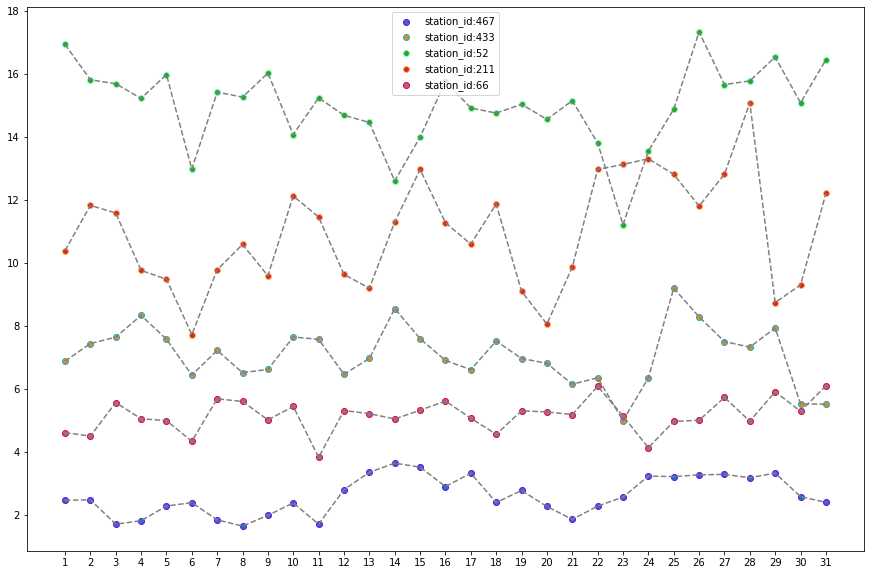

In [45]:
%%time

# mean for all months
scatter_columns(data[config_year.year], 'day', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['day']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 661, 'mean': 661.0, 'median': 661.0, 'std': nan, 'min': 661}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 738, 'mean': 738.0, 'median': 738.0, 'std': nan, 'min': 738}


  0%|          | 0/1 [00:00<?, ?it/s]

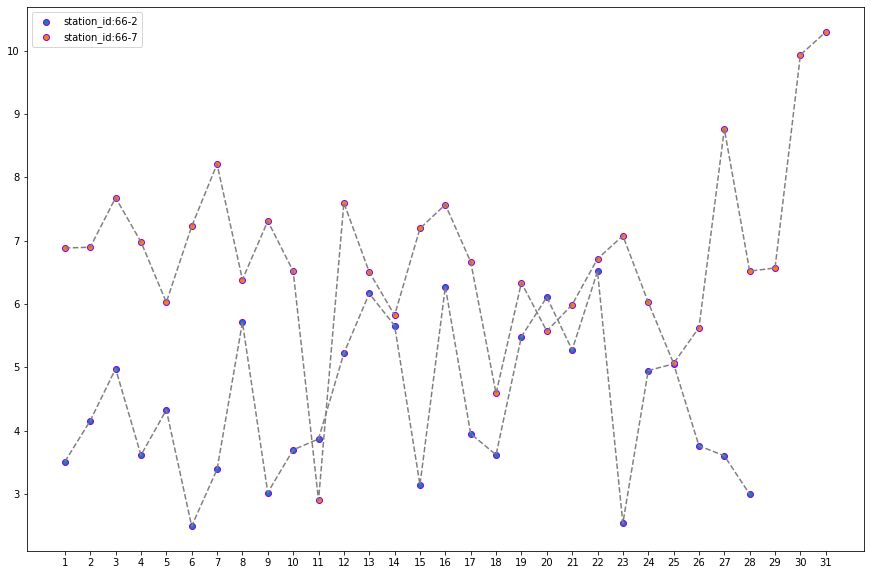

CPU times: user 754 ms, sys: 651 ms, total: 1.41 s
Wall time: 9.08 s


In [54]:
%%time

station_of_interest = 66

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 661, 'mean': 661.0, 'median': 661.0, 'std': nan, 'min': 661}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 738, 'mean': 738.0, 'median': 738.0, 'std': nan, 'min': 738}


  0%|          | 0/1 [00:00<?, ?it/s]

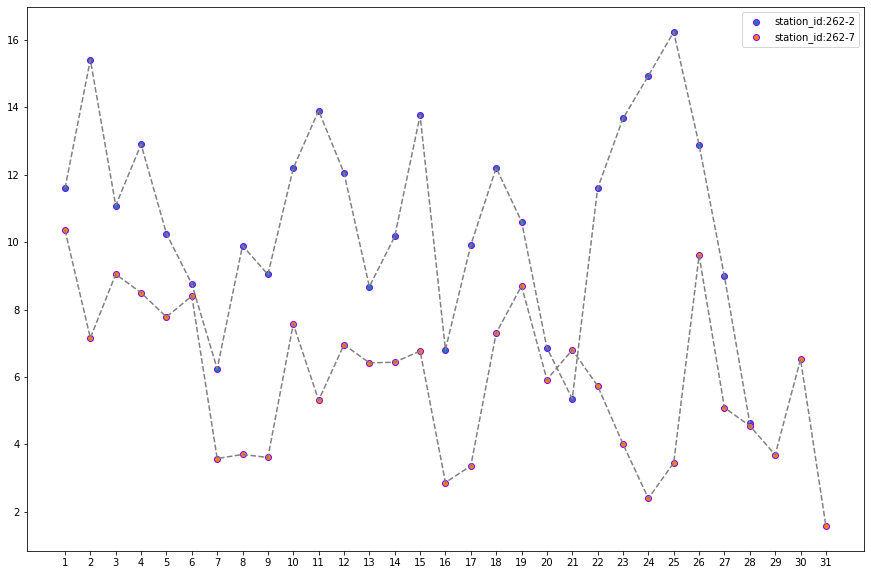

CPU times: user 1.22 s, sys: 115 ms, total: 1.33 s
Wall time: 8.68 s


In [55]:
%%time

station_of_interest = 262

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 8763, 'mean': 8718.901768172887, 'median': 8761.0, 'std': 256.85607925377843, 'min': 5079}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 2.35 s, sys: 0 ns, total: 2.35 s
Wall time: 13.6 s


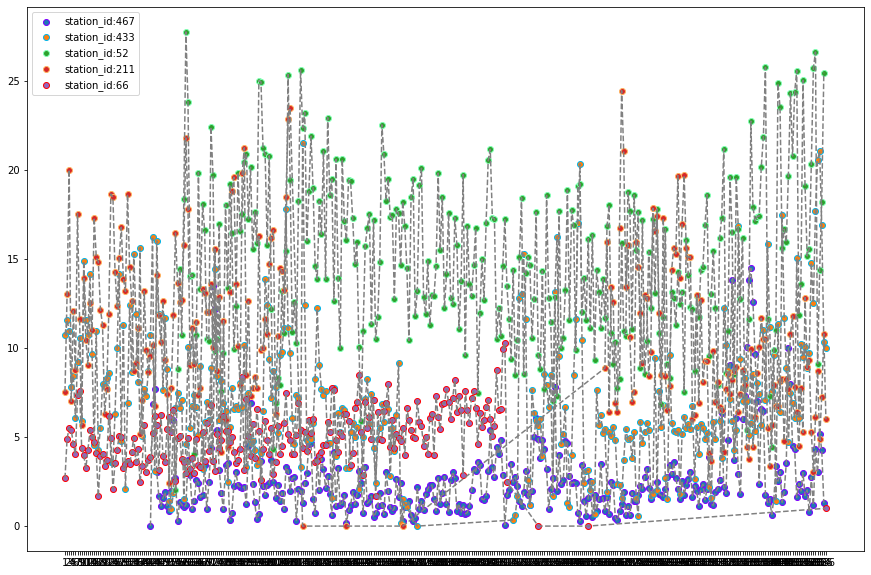

In [46]:
%%time

scatter_columns(data[config_year.year], 'dayofyear', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofyear']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8763, 'mean': 8718.901768172887, 'median': 8761.0, 'std': 256.85607925377843, 'min': 5079}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.5 s, sys: 168 ms, total: 1.66 s
Wall time: 12.5 s


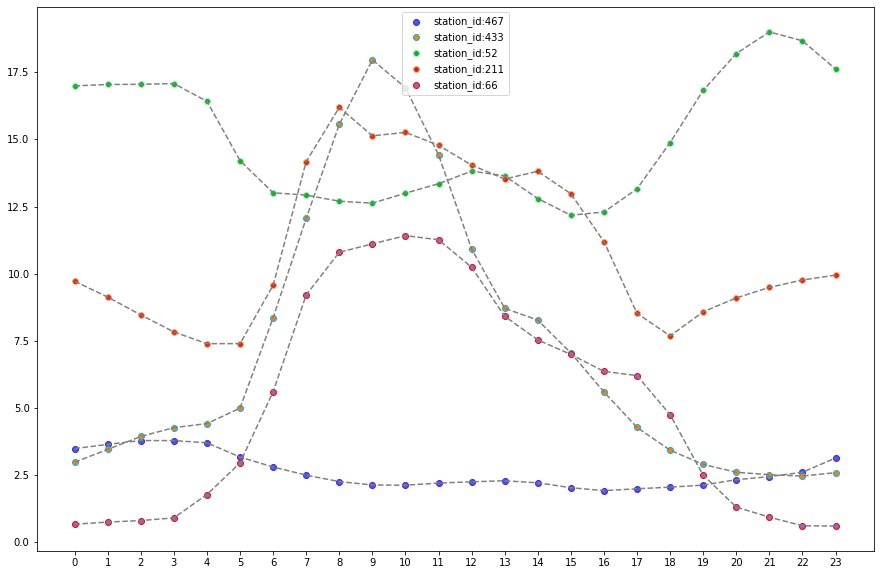

In [47]:
%%time

scatter_columns(data[config_year.year], 'hour', 'num_bikes_available', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 24, 'mean': 23.93452380952381, 'median': 24.0, 'std': 1.0764414587629505, 'min': 3}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 771 ms, sys: 1.05 s, total: 1.82 s
Wall time: 13 s


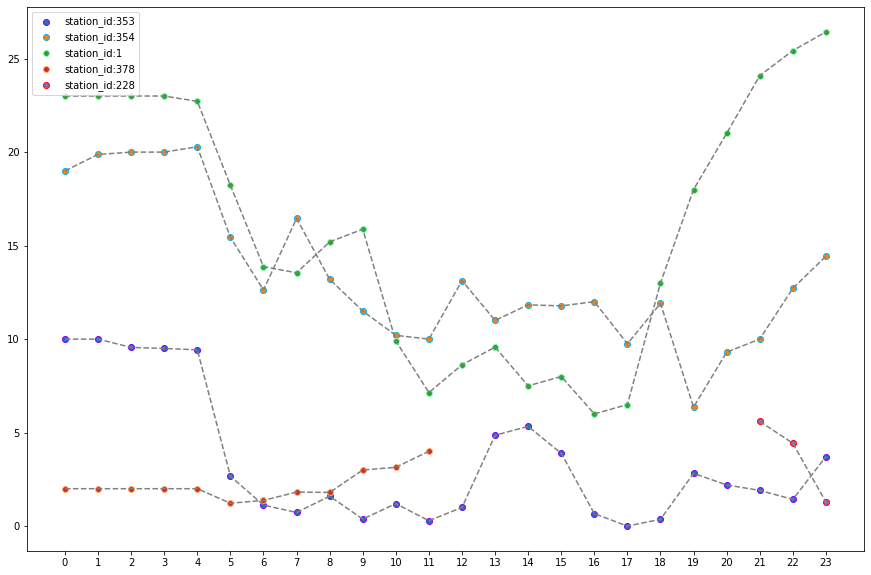

In [48]:
%%time

day_of_interest = 200
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'num_bikes_available', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 24, 'mean': 23.897435897435898, 'median': 24.0, 'std': 1.2341218146890671, 'min': 3}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.76 s, sys: 3.94 ms, total: 1.76 s
Wall time: 13 s


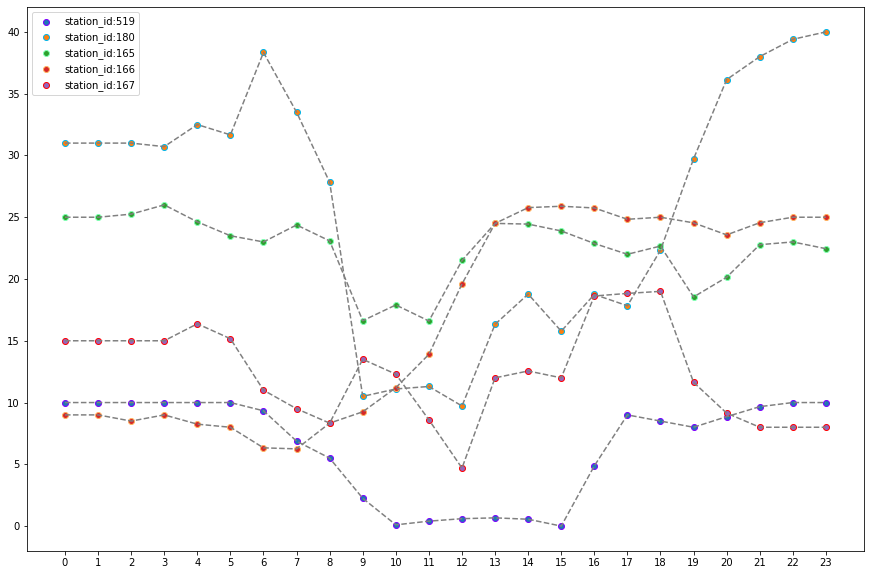

In [49]:
%%time

# https://es.wikipedia.org/wiki/23_de_abril  
# data[config_year.year][data[config_year.year].dayofyear_last_updated_date == 113]

day_of_interest = 113
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'num_bikes_available', 
    'station_id', 
    tail=False,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 711, 'mean': 711.0, 'median': 711.0, 'std': nan, 'min': 711}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 713, 'mean': 713.0, 'median': 713.0, 'std': nan, 'min': 713}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 722, 'mean': 722.0, 'median': 722.0, 'std': nan, 'min': 722}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 716, 'mean': 716.0, 'median': 716.0, 'std': nan, 'min': 716}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 747, 'mean': 747.0, 'median': 747.0, 'std': nan, 'min': 747}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 748, 'mean': 748.0, 'median': 748.0, 'std': nan, 'min': 748}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 722, 'mean': 722.0, 'median': 722.0, 'std': nan, 'min': 722}


  0%|          | 0/1 [00:00<?, ?it/s]

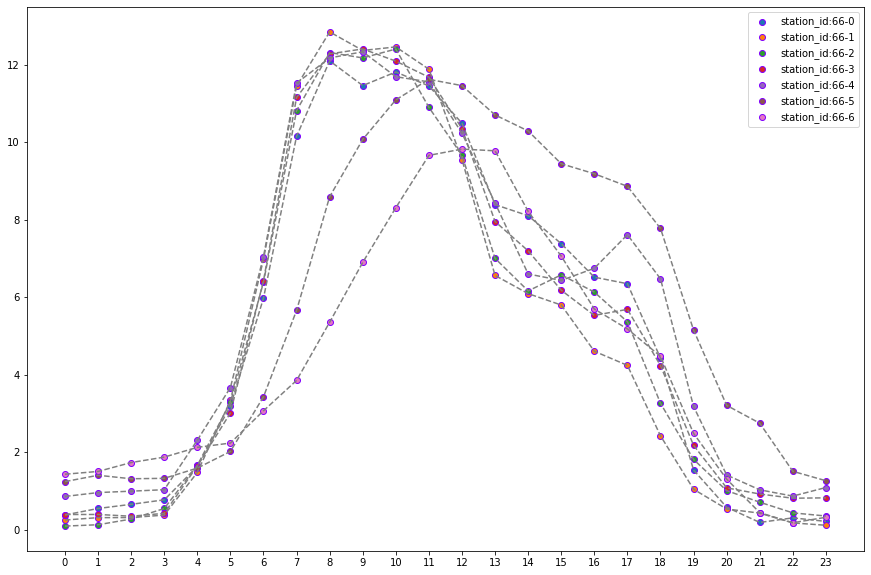

CPU times: user 4.23 s, sys: 142 ms, total: 4.37 s
Wall time: 30.3 s


In [50]:
%%time

station_of_interest = 66

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 1237, 'mean': 1237.0, 'median': 1237.0, 'std': nan, 'min': 1237}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1243, 'mean': 1243.0, 'median': 1243.0, 'std': nan, 'min': 1243}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1266, 'mean': 1266.0, 'median': 1266.0, 'std': nan, 'min': 1266}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1240, 'mean': 1240.0, 'median': 1240.0, 'std': nan, 'min': 1240}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1274, 'mean': 1274.0, 'median': 1274.0, 'std': nan, 'min': 1274}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1250, 'mean': 1250.0, 'median': 1250.0, 'std': nan, 'min': 1250}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1249, 'mean': 1249.0, 'median': 1249.0, 'std': nan, 'min': 1249}


  0%|          | 0/1 [00:00<?, ?it/s]

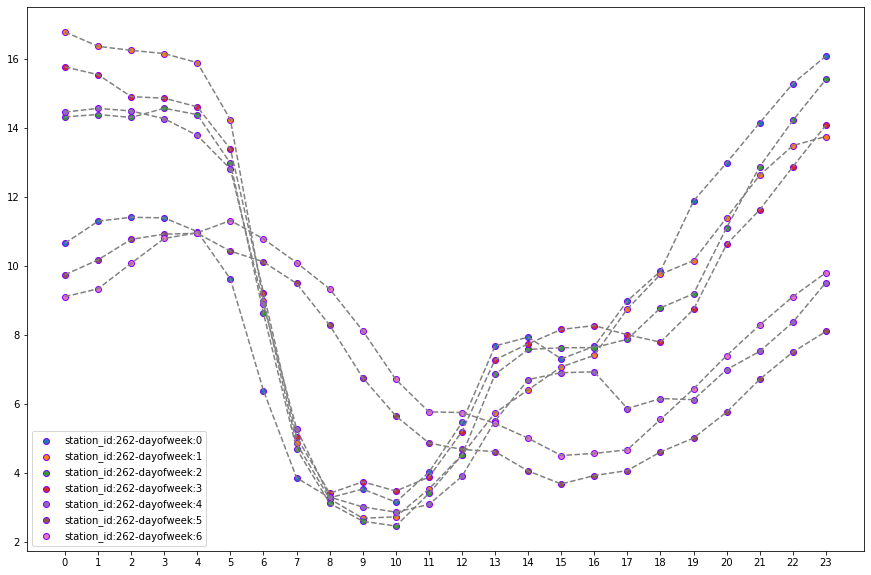

CPU times: user 3.58 s, sys: 513 ms, total: 4.1 s
Wall time: 30.8 s


In [51]:
%%time

station_of_interest = 262

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'num_bikes_available', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'dayofweek:{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

## 2021 is_charging_station

In [70]:
%%time

print(stats.describe(data[config_year.year].is_charging_station))
data[config_year.year].is_charging_station.describe().compute()

DescribeResult(nobs=4437921, minmax=(1, 1), mean=1.0, variance=0.0, skewness=0.0, kurtosis=-3.0)
CPU times: user 580 ms, sys: 244 ms, total: 823 ms
Wall time: 4.48 s


count    4437921.0
mean           1.0
std            0.0
min            1.0
25%            1.0
50%            1.0
75%            1.0
max            1.0
Name: is_charging_station, dtype: float64

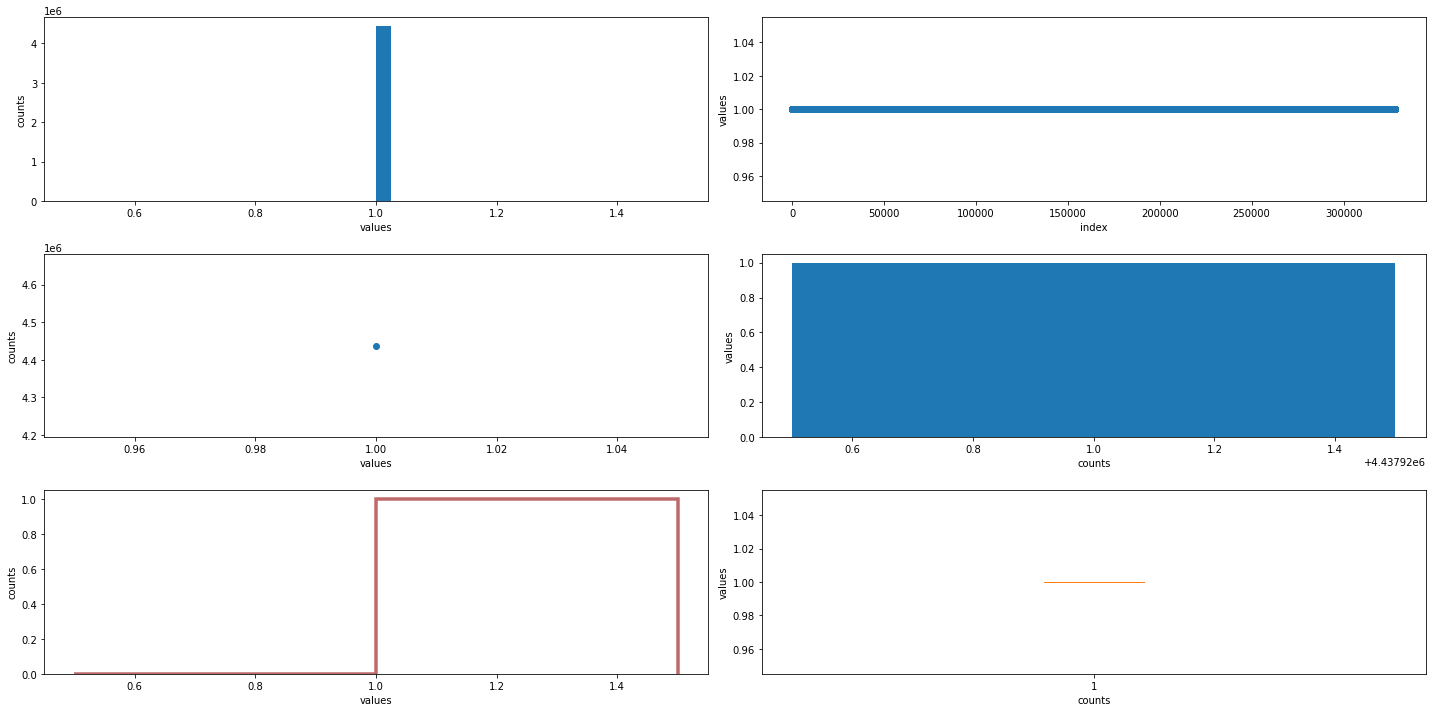

CPU times: user 7.19 s, sys: 143 ms, total: 7.33 s
Wall time: 8.93 s


In [71]:
%%time

show_counts(data[config_year.year].is_charging_station.compute())

## 2021 status

In [72]:
%%time

print(stats.describe(data[config_year.year].status))
data[config_year.year].status.describe().compute()

DescribeResult(nobs=4437921, minmax=(0, 3), mean=0.0006631483525731981, variance=0.0008902928296135081, skewness=53.449085506148606, kurtosis=3411.91699047574)
CPU times: user 930 ms, sys: 0 ns, total: 930 ms
Wall time: 5 s


count    4.437921e+06
mean     6.631484e-04
std      2.983778e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.000000e+00
Name: status, dtype: float64

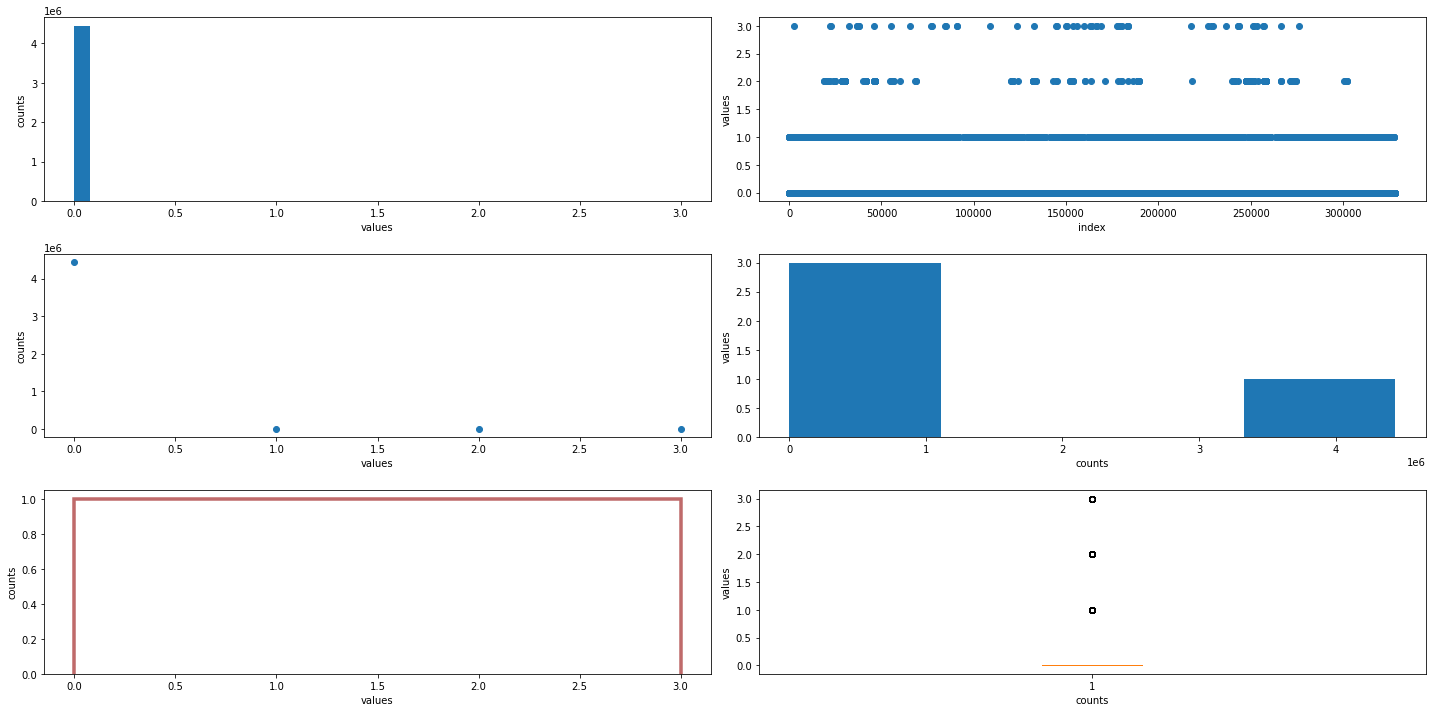

CPU times: user 8.19 s, sys: 8.49 ms, total: 8.2 s
Wall time: 9.78 s


In [73]:
%%time

show_counts(data[config_year.year].status.compute())

## 2021 is_installed

In [74]:
%%time

print(stats.describe(data[config_year.year].is_installed))
data[config_year.year].is_installed.describe().compute()

DescribeResult(nobs=4437921, minmax=(0, 1), mean=0.999983776187093, variance=1.6223553350549335e-05, skewness=-248.26355286850523, kurtosis=61632.791682891824)
CPU times: user 831 ms, sys: 120 ms, total: 951 ms
Wall time: 4.92 s


count    4.437921e+06
mean     9.999838e-01
std      4.027847e-03
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_installed, dtype: float64

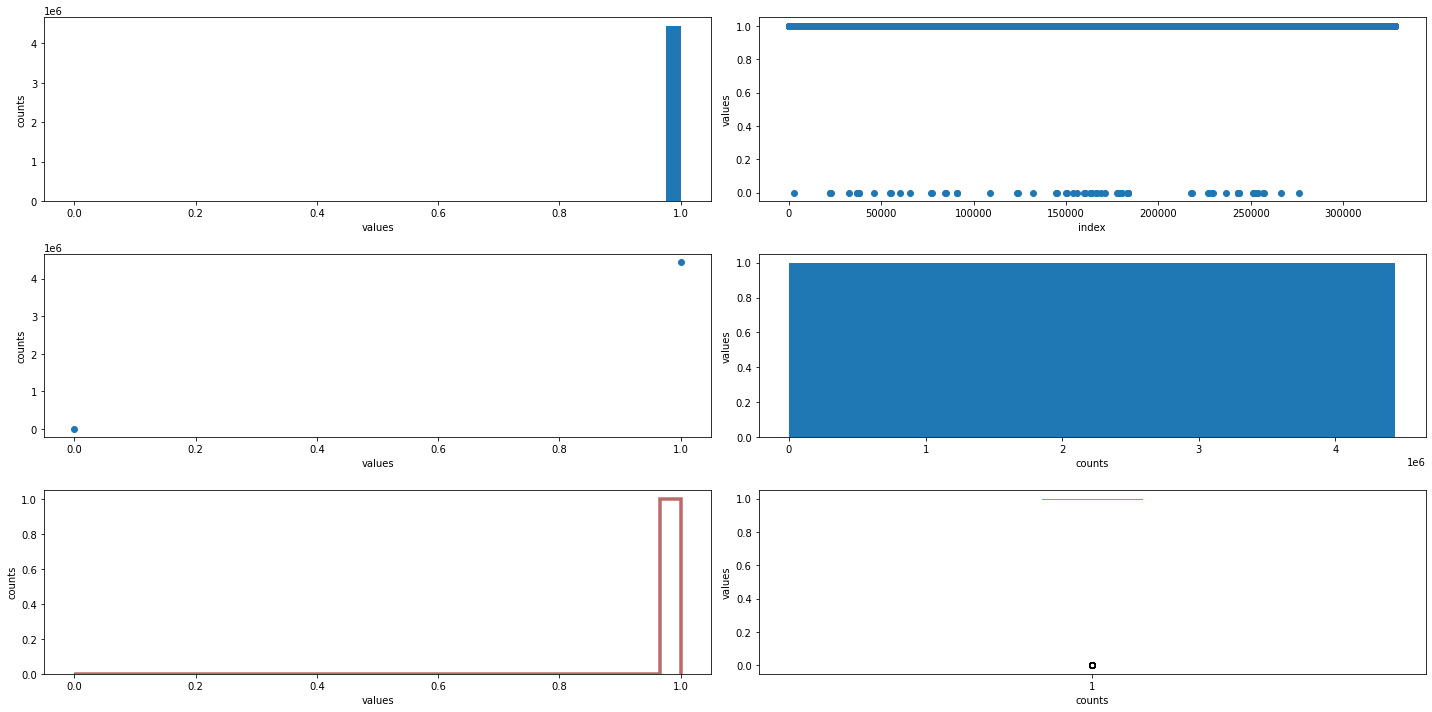

CPU times: user 7.33 s, sys: 187 ms, total: 7.52 s
Wall time: 9.04 s


In [75]:
%%time

show_counts(data[config_year.year].is_installed.compute())

## 2021 is_renting

In [76]:
%%time

print(stats.describe(data[config_year.year].is_renting))
data[config_year.year].is_renting.describe().compute()

DescribeResult(nobs=4437921, minmax=(0, 1), mean=0.999385297755413, variance=0.0006143245241637451, skewness=-40.29645766951266, kurtosis=1621.8045007108403)
CPU times: user 907 ms, sys: 0 ns, total: 907 ms
Wall time: 5.01 s


count    4.437921e+06
mean     9.993853e-01
std      2.478557e-02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_renting, dtype: float64

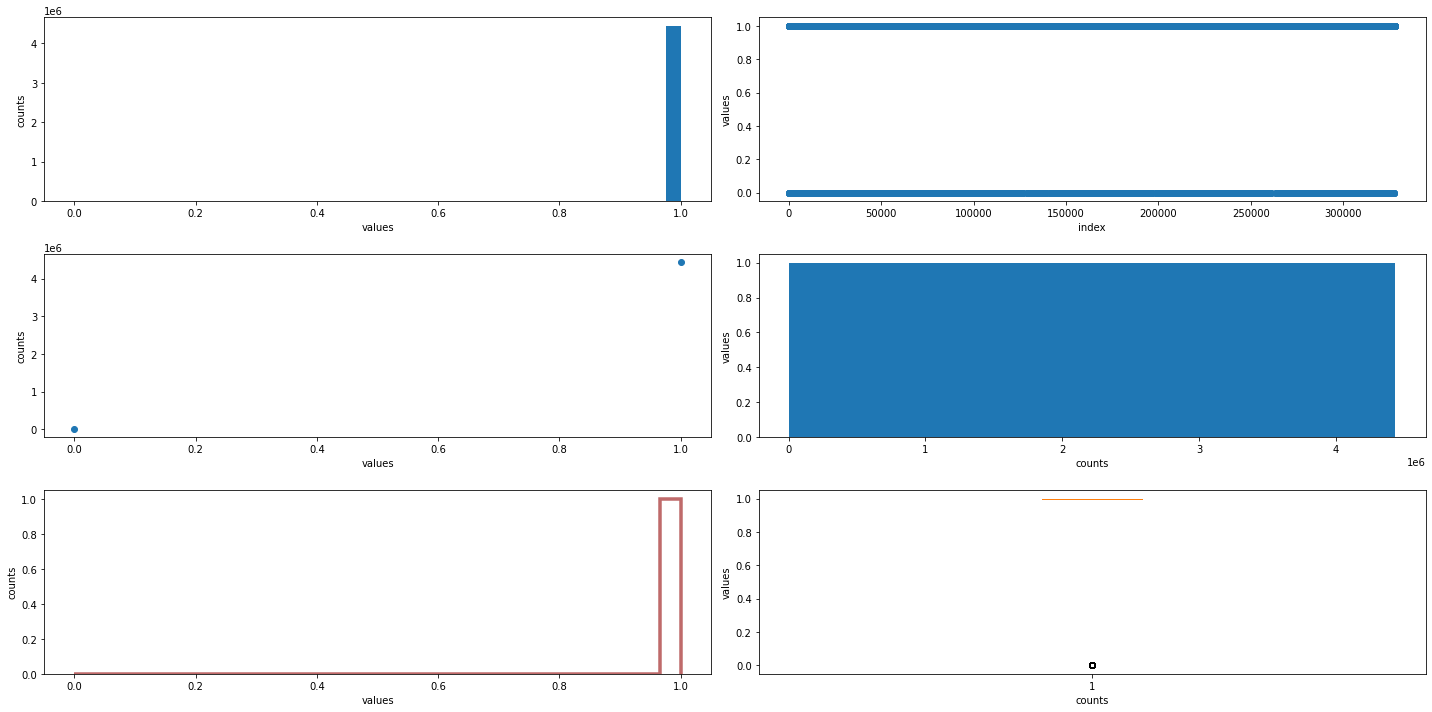

CPU times: user 7.8 s, sys: 0 ns, total: 7.8 s
Wall time: 9.47 s


In [77]:
%%time

show_counts(data[config_year.year].is_renting.compute())

## 2021 is_returning

In [78]:
%%time

print(stats.describe(data[config_year.year].is_returning))
data[config_year.year].is_returning.describe().compute()

DescribeResult(nobs=4437921, minmax=(0, 1), mean=0.999385297755413, variance=0.0006143245241637451, skewness=-40.29645766951266, kurtosis=1621.8045007108403)
CPU times: user 635 ms, sys: 217 ms, total: 851 ms
Wall time: 4.76 s


count    4.437921e+06
mean     9.993853e-01
std      2.478557e-02
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: is_returning, dtype: float64

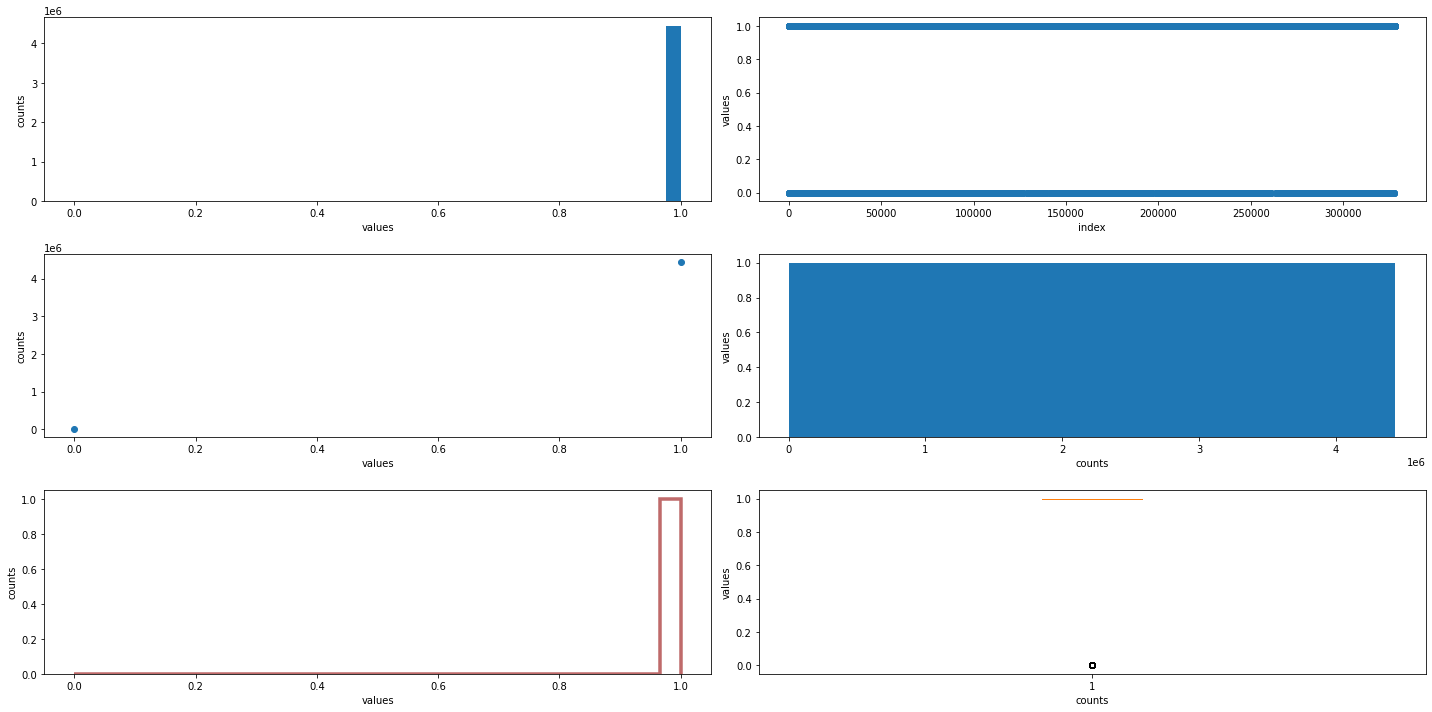

CPU times: user 7.25 s, sys: 139 ms, total: 7.39 s
Wall time: 9.2 s


In [79]:
%%time

show_counts(data[config_year.year].is_returning.compute())

## 2021 ctx0

In [56]:
%%time

print(stats.describe(data[config_year.year].ctx0))
data[config_year.year].ctx0.describe().compute()

DescribeResult(nobs=4437921, minmax=(0.0, 0.9999999999999998), mean=0.5852167570106849, variance=0.07782104471916622, skewness=-0.44340863201340114, kurtosis=-0.916774651287394)
CPU times: user 787 ms, sys: 4.28 ms, total: 791 ms
Wall time: 4.43 s


count    4.437921e+06
mean     5.852168e-01
std      2.789642e-01
min      0.000000e+00
25%      3.888889e-01
50%      6.369048e-01
75%      8.333333e-01
max      1.000000e+00
Name: ctx0, dtype: float64

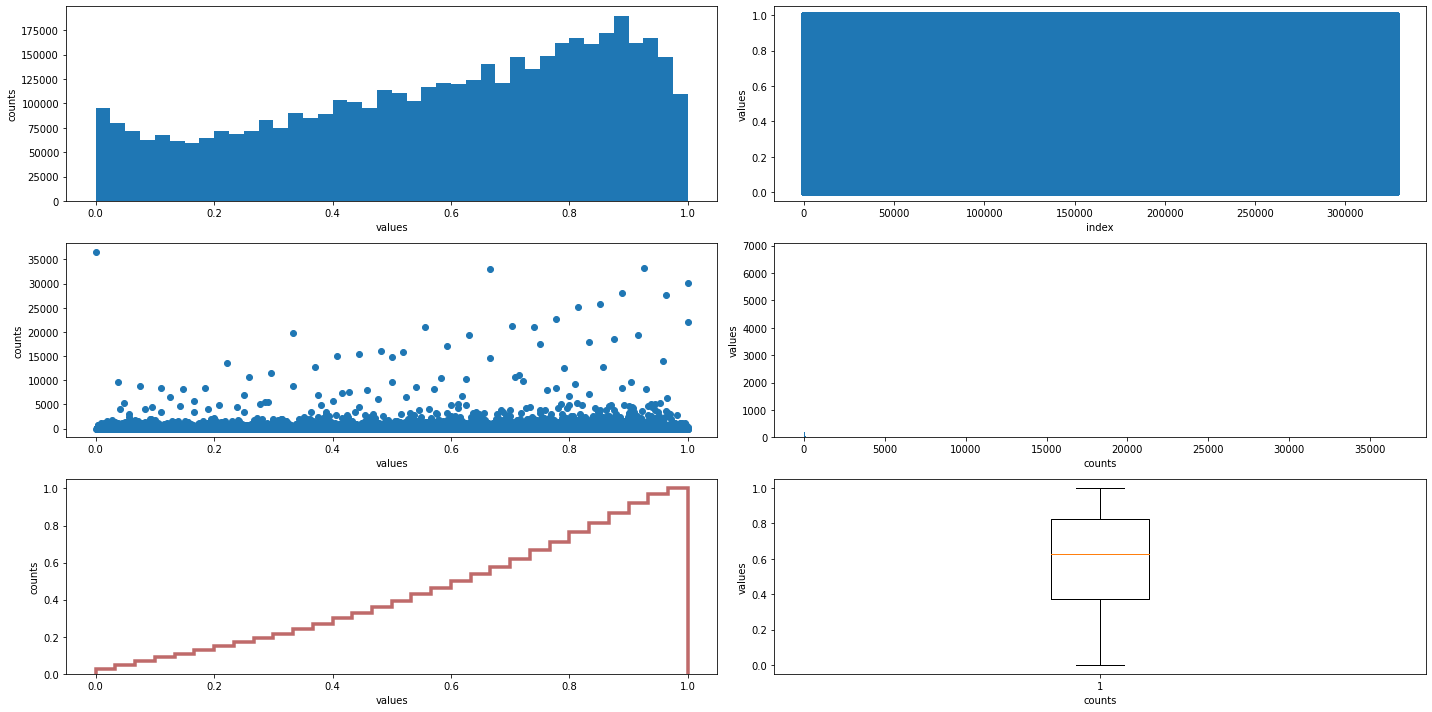

CPU times: user 1min 8s, sys: 9.26 s, total: 1min 17s
Wall time: 1min 17s


In [57]:
%%time

show_counts(data[config_year.year].ctx0.compute())

348
value counts stats {'max': 8763, 'mean': 8718.901768172887, 'median': 8761.0, 'std': 256.85607925377843, 'min': 5079}


  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 787 ms, sys: 0 ns, total: 787 ms
Wall time: 4.31 s


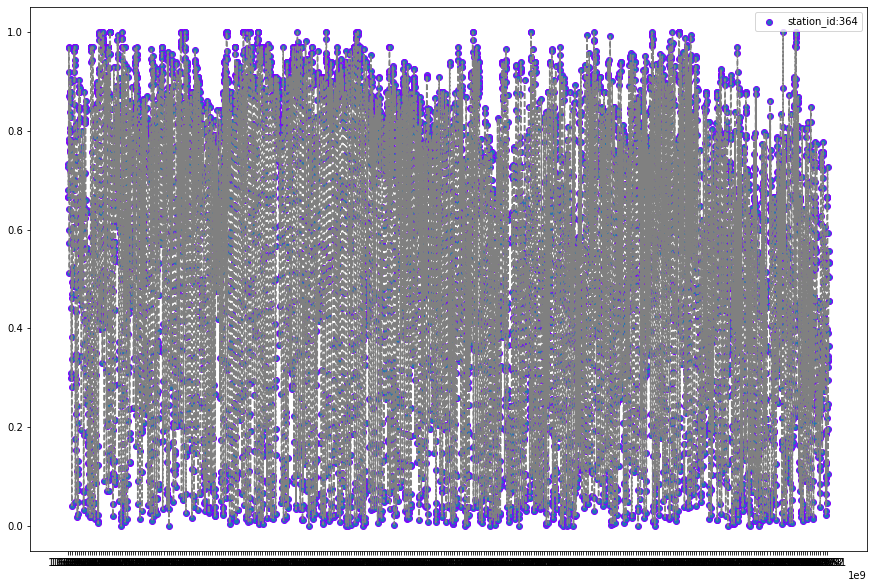

In [58]:
%%time

# Checking availibilty for docks all year
xtikcs_scatter = [uniques['timestamp'][i] for i, x in enumerate(uniques['timestamp']) if i%25==0]
print(len(xtikcs_scatter))

scatter_columns(
    data[config_year.year], 
    'timestamp', 
    'ctx0', 
    'station_id', 
    tail=False,
    xticks=np.asarray(xtikcs_scatter),
    figsize=(15,10),
    count=1
)


value counts stats {'max': 8763, 'mean': 8718.901768172887, 'median': 8761.0, 'std': 256.85607925377843, 'min': 5079}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 4.87 s, sys: 239 ms, total: 5.11 s
Wall time: 16.5 s


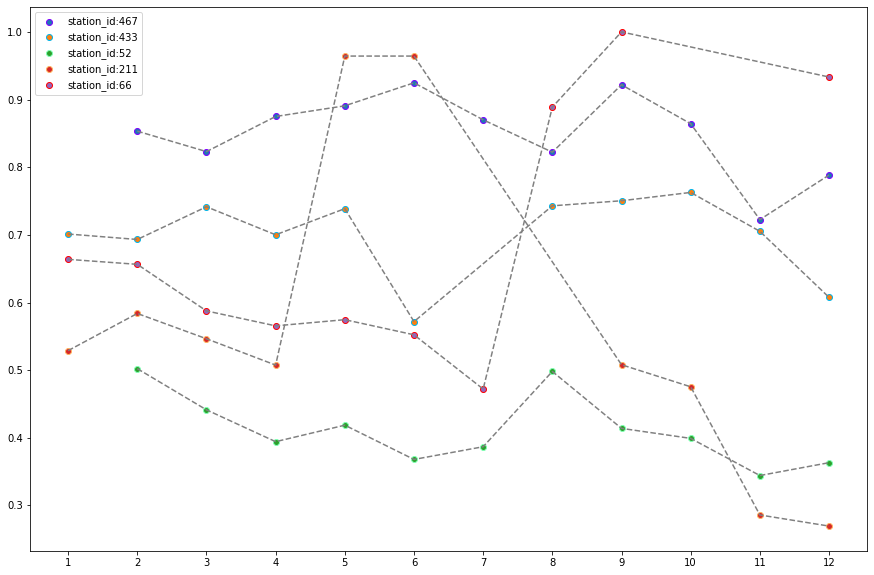

In [59]:
%%time

scatter_columns(
    data[config_year.year], 
    'month', 
    'ctx0', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['month']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8763, 'mean': 8718.901768172887, 'median': 8761.0, 'std': 256.85607925377843, 'min': 5079}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.8 s, sys: 0 ns, total: 1.8 s
Wall time: 13.7 s


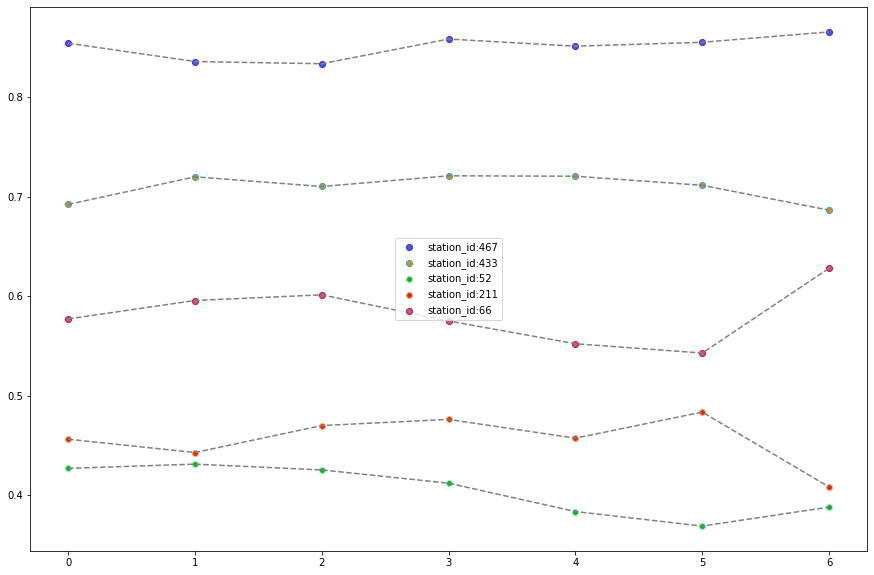

In [60]:
%%time

scatter_columns(
    data[config_year.year], 
    'dayofweek', 
    'ctx0', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofweek']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8763, 'mean': 8718.901768172887, 'median': 8761.0, 'std': 256.85607925377843, 'min': 5079}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.85 s, sys: 0 ns, total: 1.85 s
Wall time: 13 s


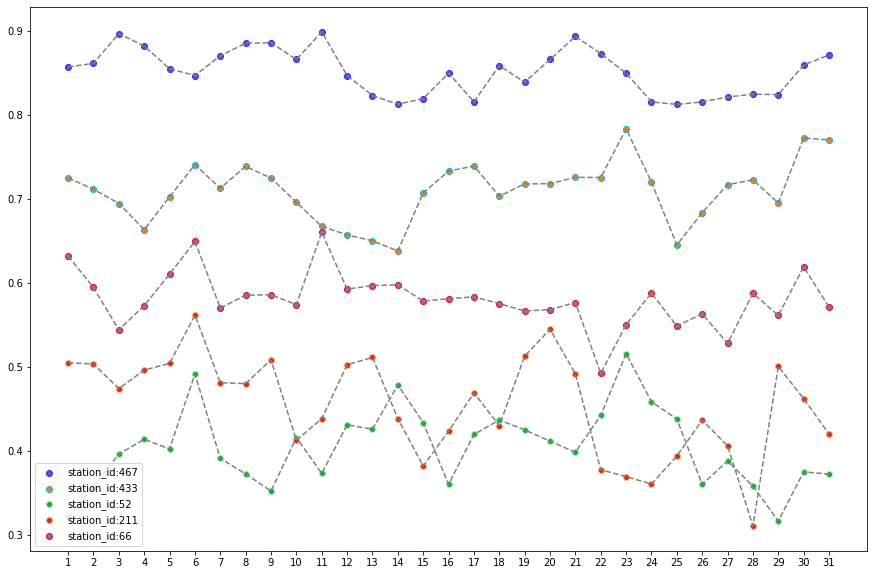

In [61]:
%%time

# mean for all months
scatter_columns(data[config_year.year], 'day', 'ctx0', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['day']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 661, 'mean': 661.0, 'median': 661.0, 'std': nan, 'min': 661}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 738, 'mean': 738.0, 'median': 738.0, 'std': nan, 'min': 738}


  0%|          | 0/1 [00:00<?, ?it/s]

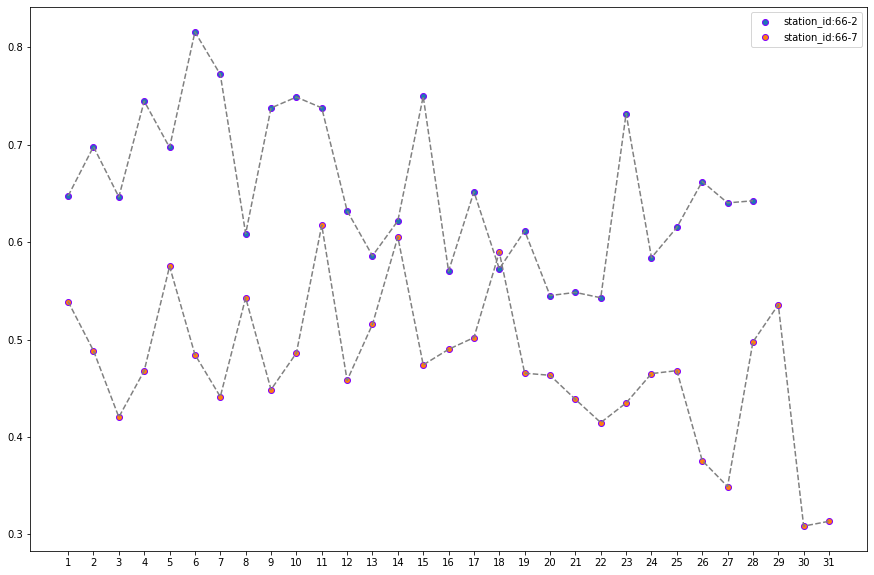

CPU times: user 1.35 s, sys: 0 ns, total: 1.35 s
Wall time: 9.08 s


In [62]:
%%time

station_of_interest = 66

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 661, 'mean': 661.0, 'median': 661.0, 'std': nan, 'min': 661}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 738, 'mean': 738.0, 'median': 738.0, 'std': nan, 'min': 738}


  0%|          | 0/1 [00:00<?, ?it/s]

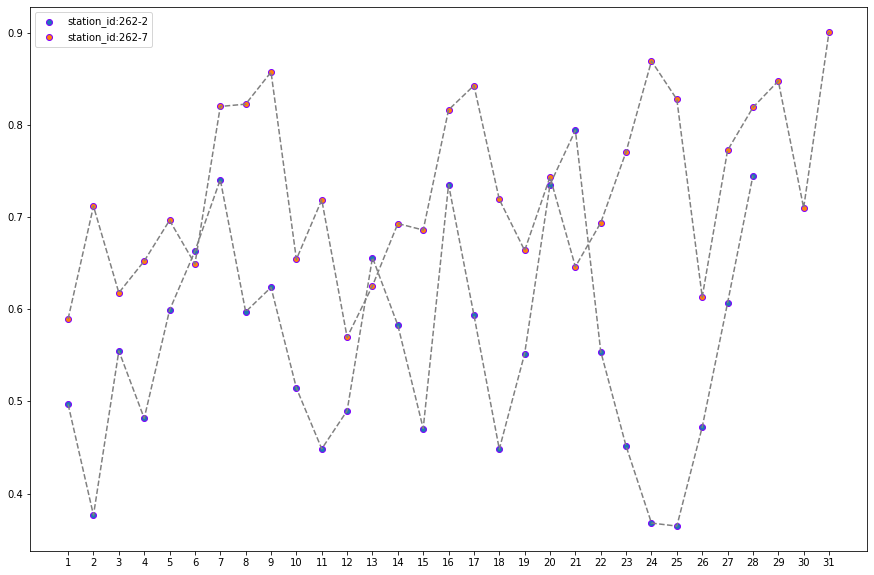

CPU times: user 1.39 s, sys: 0 ns, total: 1.39 s
Wall time: 8.86 s


In [63]:
%%time

station_of_interest = 262

for month in [2,7]:#uniques['month'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].month == month) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'day', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['day']),
        figsize=(15,10),
        count=1, 
        label=f'{month}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 8763, 'mean': 8718.901768172887, 'median': 8761.0, 'std': 256.85607925377843, 'min': 5079}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 2.04 s, sys: 60.7 ms, total: 2.1 s
Wall time: 13.2 s


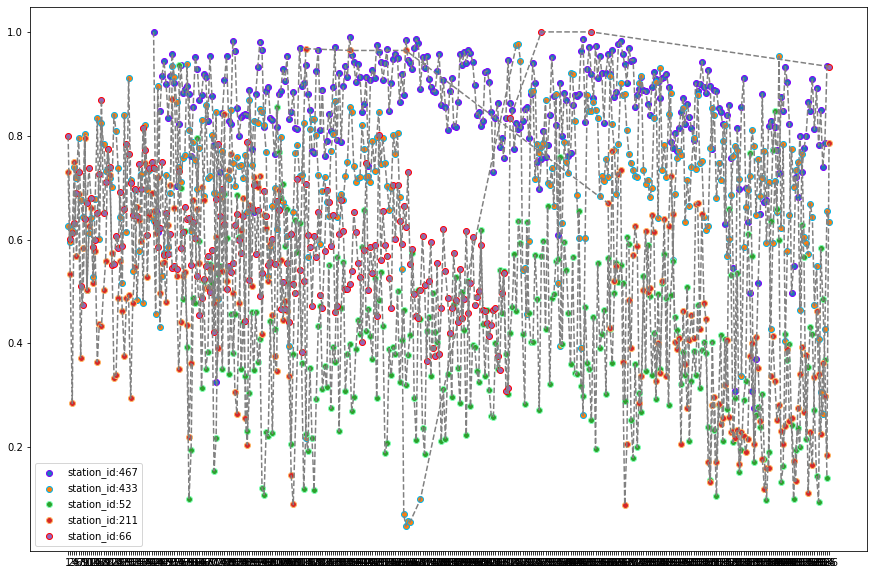

In [64]:
%%time

scatter_columns(data[config_year.year], 'dayofyear', 'ctx0', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['dayofyear']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 8763, 'mean': 8718.901768172887, 'median': 8761.0, 'std': 256.85607925377843, 'min': 5079}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.41 s, sys: 307 ms, total: 1.72 s
Wall time: 12.9 s


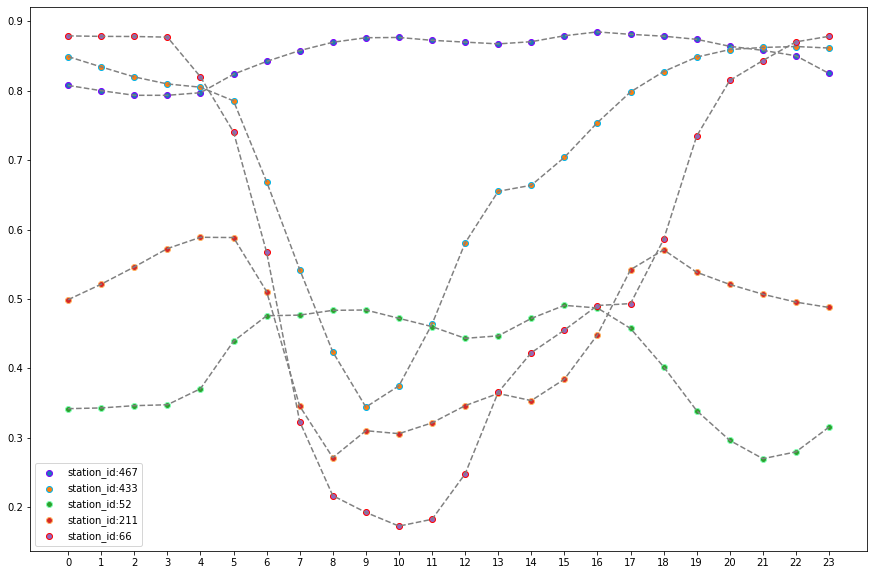

In [65]:
%%time

scatter_columns(data[config_year.year], 'hour', 'ctx0', 'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)

value counts stats {'max': 24, 'mean': 23.93452380952381, 'median': 24.0, 'std': 1.0764414587629505, 'min': 3}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.07 s, sys: 740 ms, total: 1.81 s
Wall time: 13.3 s


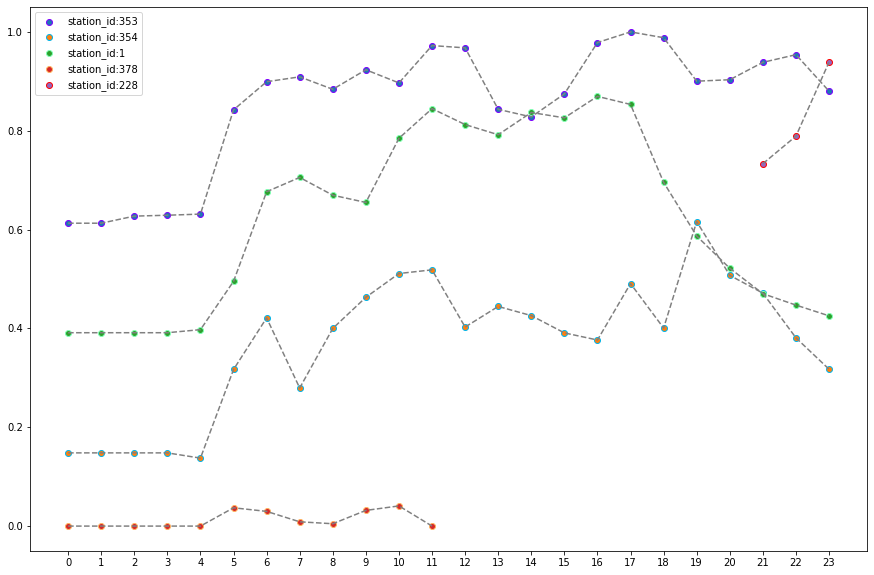

In [66]:
%%time

day_of_interest = 200
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'ctx0', 
    'station_id', 
    tail=True,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 24, 'mean': 23.897435897435898, 'median': 24.0, 'std': 1.2341218146890671, 'min': 3}


  0%|          | 0/5 [00:00<?, ?it/s]

CPU times: user 1.32 s, sys: 335 ms, total: 1.66 s
Wall time: 13.2 s


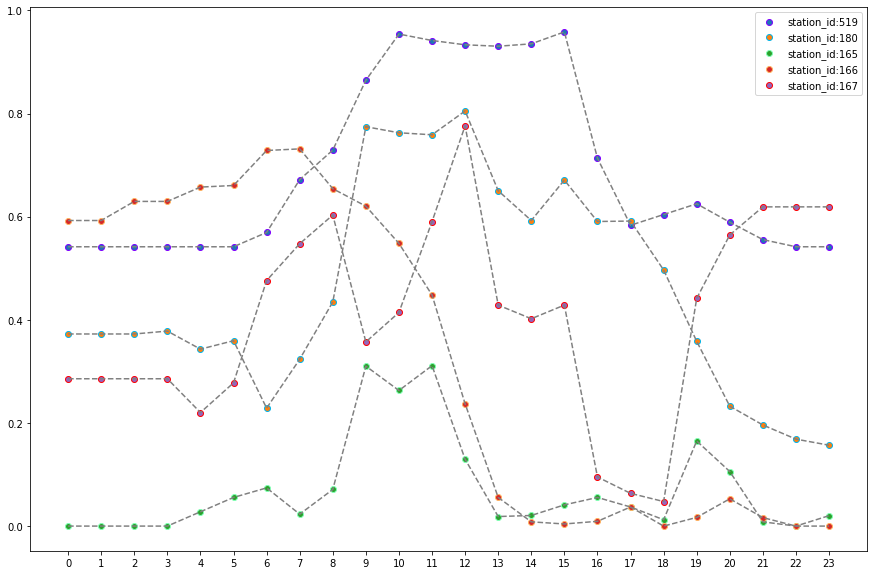

In [67]:
%%time

# https://es.wikipedia.org/wiki/23_de_abril  
# data[config_year.year][data[config_year.year].dayofyear_last_updated_date == 113]

day_of_interest = 113
data_of_interest = data[config_year.year][data[config_year.year].dayofyear == day_of_interest]

scatter_columns(
    data_of_interest, 
    'hour', 
    'ctx0', 
    'station_id', 
    tail=False,
    xticks=np.asarray(uniques['hour']),
    figsize=(15,10),
    count=5
)


value counts stats {'max': 711, 'mean': 711.0, 'median': 711.0, 'std': nan, 'min': 711}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 713, 'mean': 713.0, 'median': 713.0, 'std': nan, 'min': 713}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 722, 'mean': 722.0, 'median': 722.0, 'std': nan, 'min': 722}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 716, 'mean': 716.0, 'median': 716.0, 'std': nan, 'min': 716}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 747, 'mean': 747.0, 'median': 747.0, 'std': nan, 'min': 747}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 748, 'mean': 748.0, 'median': 748.0, 'std': nan, 'min': 748}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 722, 'mean': 722.0, 'median': 722.0, 'std': nan, 'min': 722}


  0%|          | 0/1 [00:00<?, ?it/s]

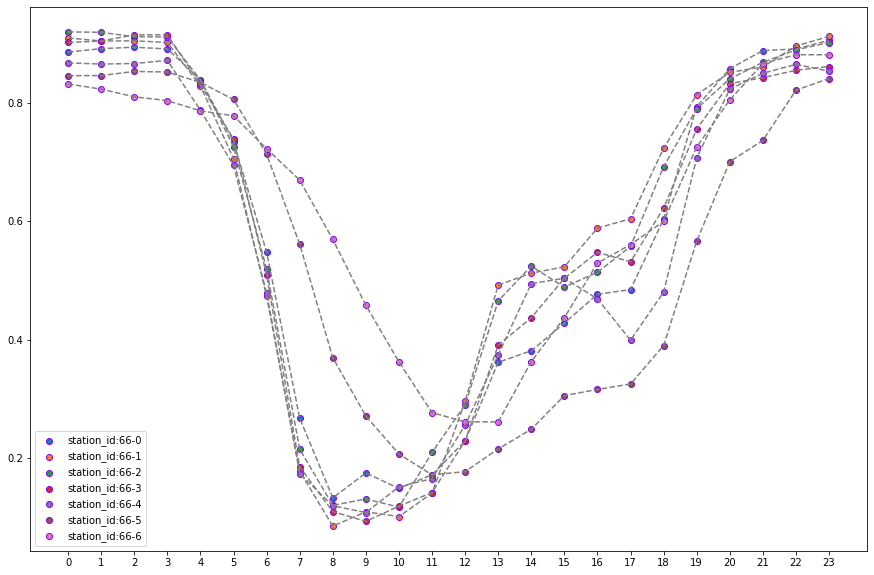

CPU times: user 4.04 s, sys: 34.4 ms, total: 4.07 s
Wall time: 30.4 s


In [68]:
%%time

station_of_interest = 66

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()

value counts stats {'max': 1237, 'mean': 1237.0, 'median': 1237.0, 'std': nan, 'min': 1237}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1243, 'mean': 1243.0, 'median': 1243.0, 'std': nan, 'min': 1243}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1266, 'mean': 1266.0, 'median': 1266.0, 'std': nan, 'min': 1266}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1240, 'mean': 1240.0, 'median': 1240.0, 'std': nan, 'min': 1240}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1274, 'mean': 1274.0, 'median': 1274.0, 'std': nan, 'min': 1274}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1250, 'mean': 1250.0, 'median': 1250.0, 'std': nan, 'min': 1250}


  0%|          | 0/1 [00:00<?, ?it/s]

value counts stats {'max': 1249, 'mean': 1249.0, 'median': 1249.0, 'std': nan, 'min': 1249}


  0%|          | 0/1 [00:00<?, ?it/s]

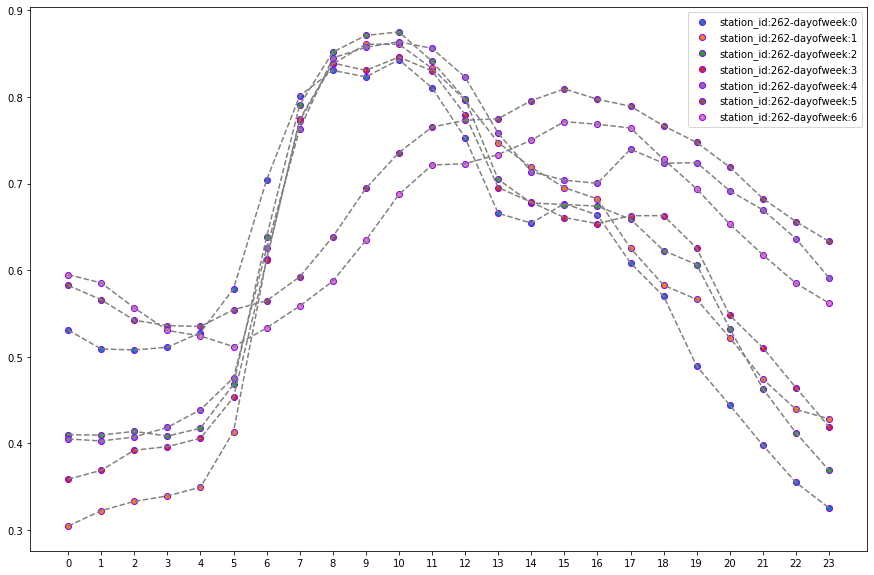

CPU times: user 4.18 s, sys: 13.4 ms, total: 4.2 s
Wall time: 30.7 s


In [69]:
%%time

station_of_interest = 262

for dayaofweek in uniques['dayofweek'].sort_values():
    
    data_of_interest = data[config_year.year][(data[config_year.year].dayofweek == dayaofweek) & (data[config_year.year].station_id == station_of_interest)]

    scatter_columns(
        data_of_interest, 
        'hour', 
        'ctx0', 
        'station_id', 
        tail=False,
        xticks=np.asarray(uniques['hour']),
        figsize=(15,10),
        count=1, 
        label=f'dayofweek:{dayaofweek}'
    )

#plt.legend(uniques['dayofweek_last_updated_date']) # keys.astype(np.int)
plt.show()